In [1]:
import torch
from dataset import EMNIST
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data_root = Path('archive')
batch_size_train, batch_size_test = 128, 1000
device = torch.device('cuda:0')

In [3]:
train_set = EMNIST(data_root / 'emnist-digits-train.csv')
test_set = EMNIST(data_root / 'emnist-digits-test.csv')

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, num_workers=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_train, num_workers=8)

In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
model = torch.load('./best_model.pth')

In [7]:
# imgs, labels = next(iter(test_loader))
# reconstructions = model(imgs.cuda()).cpu()
# for i in range(20):
#     dic = {str(labels[i]): imgs[i][0], 'reconstruction': reconstructions[i][0].detach()}
#     visualize(**dic)

In [8]:
df = {'label': [], 'encode0': [], 'encode1': []}

for imgs, labels in test_loader:
            imgs = imgs.to(device)
            encoded = model.encoder(imgs).cpu()
            for label, enc in zip(labels, encoded):
                df['label'].append(str(label.item()))
                df['encode0'].append(enc[0].item())
                df['encode1'].append(enc[1].item())

df = pd.DataFrame(df)
df

label   encode0   encode1
0         0  0.667449  0.134341
1         9  0.210576  0.710448
2         7  0.295722  0.593383
3         9  0.419514  0.840994
4         2  0.229435  0.216865
...     ...       ...       ...
39995     9  0.607477  0.863105
39996     7  0.495609  0.799195
39997     3  0.750525  0.474694
39998     7  0.819982  0.753830
39999     4  0.671190  0.996907

[40000 rows x 3 columns]

<AxesSubplot:xlabel='encode0', ylabel='encode1'>

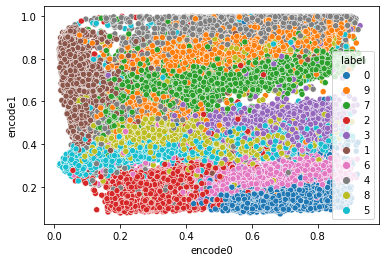

In [9]:
sns.scatterplot(data=df, x="encode0", y="encode1", hue="label")

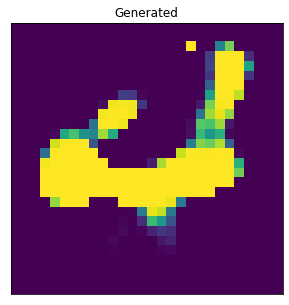

In [10]:
generated = model.decoder(torch.tensor([[2.5, 6.0]]).to(device)).cpu().detach()
visualize(generated=generated.squeeze())

In [11]:
img, label = test_set[1]
model.encoder(torch.unsqueeze(img, 1).cuda())

tensor([[0.2106, 0.7104]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [12]:
decoder = model.decoder.cuda()
decoder.eval()
dummy_input = torch.zeros(1, 2).cuda()
torch.onnx.export(decoder, dummy_input, 'decoder.onnx', verbose=True, opset_version=13)

graph(%input.1 : Float(1, 2, strides=[2, 1], requires_grad=0, device=cuda:0),
      %0.weight : Float(10, 2, strides=[2, 1], requires_grad=1, device=cuda:0),
      %0.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0),
      %2.weight : Float(32, 10, strides=[10, 1], requires_grad=1, device=cuda:0),
      %2.bias : Float(32, strides=[1], requires_grad=1, device=cuda:0),
      %4.weight : Float(128, 32, strides=[32, 1], requires_grad=1, device=cuda:0),
      %4.bias : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %6.weight : Float(784, 128, strides=[128, 1], requires_grad=1, device=cuda:0),
      %6.bias : Float(784, strides=[1], requires_grad=1, device=cuda:0)):
  %9 : Float(1, 10, strides=[10, 1], requires_grad=1, device=cuda:0) = onnx::Gemm[alpha=1., beta=1., transB=1](%input.1, %0.weight, %0.bias) # /home/horstl/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1753:0
  %10 : Float(1, 10, strides=[10, 1], requires_grad=1, device=cuda:0) = onnx: